<h1>ME 233 Final Project: How to house</h1>
<h3>By Jesus Cervantes, Nicholas Robles, Joanna Liu, Isaiah Drummond </h3>

This project explores how different ways of assigning incoming students to dorms might impact the spread of COVID-19 on campus udner different quarantine scenarios.

# Package Imports
Put all package imports in here.

In [1]:
import numpy as np
import pandas as pd

# get_results_by_dorm class code imports:
from matplotlib import ticker
import os
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt

# Global Variables

In [2]:
#Data download filename
STUDENT_DATA_FILENAME = "student_state_merged.csv"

#Dorm assignment schemes
ASSIGN_UNIFORM = "UNIFORM"
ASSIGN_BY_RISK = "RISK"

#Interaction schemes
INTERACT_UNIFORM = "UNIFORM"

# Downloading State Data
Here, we import state-based data including the number of students coming from each state and information about the virus in that state. We then return the merged data file that has the total number of students for the class years of interest and the relevant state-wide data.

In [3]:
def read_data_from_file(student_filename, yrs):
    # student_filename: string, filename of the table with data about where students are coming from
    # yrs: int, col indices for class years to consider for moving in
    # state_filename: string, filename of the table with init conditions (S_0, E_0, etc.) by state
    
    # Add the data table (.csv, .xlsx, etc.) into the git repo, then read it in here
    # Do whatever cleaning up needs to be done and return the table
    data = pd.read_csv(student_filename)
    
    # Create data table using information from .csv
    student_data = pd.DataFrame(np.zeros((55,8)), columns=["State","Population","S_0","E_0","I_0","R_0","Rt","beta"])
    student_data.State = data.State
    student_data.Population = data[years_to_consider].sum(axis=1)
    student_data.S_0 = data.S_0
    student_data.E_0 = data.E_0
    student_data.I_0 = data.I_0
    student_data.R_0 = data.R_0
    student_data.Rt = data.R_t
    student_data.beta = data.beta
    
    return student_data

In [4]:
years_to_consider = ["UG1", "UG2"] #Subject to change pending what the state data looks like

state_based_data = read_data_from_file(STUDENT_DATA_FILENAME, years_to_consider)

# Make dorms

Here, we take our state data and make our dorms out of it. For each dorm, we assign a subset of the student population to be in that dorm. Once we have assigned the students to the dorm, we get a weighted average based on where students came from to get one single risk measure for that dorm (probably based on positivity rate of the state). A major part of our experiment is how we do the assignment, our control is assuming a uniform distribution throughout each dorm.

In [5]:
def get_dorm_assignments(n_dorms, pop, state_data, assign, dorm_pops=None):
    # n_dorms: int, number of dorms
    # pop: int, total student population
    # state_data: np array or pd dataframe, information by state w # students from state + state pos. rate
    # assign: string, determines what kind of assignment mechanism to use
    # dorm_pops (Optional): dict mapping dorms to # students in that dorm, not using for now but in case we want to make dorms unique
    
    # RETURNS: dorms, pd dataframe, each row is a dorm, the columns in order are: # students, S_0, E_0, I_0, R_0, Rt, beta
    
    # Each elem in dorms is a float that is the weighted risk of that dorm
    dorms = pd.DataFrame(np.zeros((n_dorms,7)), columns=["Students", "S_0", "E_0","I_0", "R_0", "Rt", "beta"])
    
    # Create size of each dorm such that every dorm has the same population of students.
    dorm_pop = pop / n_dorms
    
    # For the base case, we assign students uniformly to each dorm. Each dorm has same initial conditions
    # for SEIR model.
    if assign == ASSIGN_UNIFORM:
        dorms.Students = dorm_pop
        dorms.S_0 = sum(state_data.S_0 * state_data.Population) / pop
        dorms.E_0 = sum(state_data.E_0 * state_data.Population) / pop
        dorms.I_0 = sum(state_data.I_0 * state_data.Population) / pop
        dorms.R_0 = sum(state_data.R_0 * state_data.Population) / pop
        dorms.Rt = sum(state_data.Rt * state_data.Population) / pop
        dorms.beta = sum(state_data.beta * state_data.Population) / pop
        print("We are using uniform distribution")
        
    # For the alternative case, we order states by risk level and then assign equal number of students to each dorm.
    # However, we assign students based on risk level of state (i.e., students from high risk states will live in
    # same dorm whereas students from states with lower cases will live in the same space).
    elif assign == ASSIGN_BY_RISK:
        
        # Sort data by beta values from lowest to highest. This will have the students from similar states positioned
        # next to one another in the array.
        sorted_data = state_data.sort_values("beta", ascending=False).reset_index()
    
        # Set up counter that progresses through number of dorms and one that progresses through states. Set up 
        # empty arrays for the weighted averages of SEIR data for each dorm. Set up variable "current_pop" which
        # holds the number of students in a dorm as we cycle through our loop. This will never exceed dorm_pop.
        current_pop = 0
        dorm_pos = 0
        state_pos = 0
        dorm_S0 = np.zeros((n_dorms,1))
        dorm_E0 = np.zeros((n_dorms,1))
        dorm_I0 = np.zeros((n_dorms,1))
        dorm_R0 = np.zeros((n_dorms,1))
        dorm_Rt = np.zeros((n_dorms,1))
        dorm_beta = np.zeros((n_dorms,1))

        # Loop through each state in the list and fit weighted averages of SEIR data to each dorm. Ensure that each dorm
        # has the same number of students.
        while state_pos < len(sorted_data.State):
            
            # If the dorm has enough room to fit an entire state, put all the residents in the dorm. Then progress to next state.
            if current_pop + sorted_data.Population[state_pos] <= dorm_pop:
                dorm_S0[dorm_pos] = dorm_S0[dorm_pos] + (sorted_data.S_0[state_pos] * sorted_data.Population[state_pos]) / pop
                dorm_E0[dorm_pos] = dorm_E0[dorm_pos] + (sorted_data.E_0[state_pos] * sorted_data.Population[state_pos]) / pop
                dorm_I0[dorm_pos] = dorm_I0[dorm_pos] + (sorted_data.I_0[state_pos] * sorted_data.Population[state_pos]) / pop
                dorm_R0[dorm_pos] = dorm_R0[dorm_pos] + (sorted_data.R_0[state_pos] * sorted_data.Population[state_pos]) / pop
                dorm_Rt[dorm_pos] = dorm_Rt[dorm_pos] + (sorted_data.Rt[state_pos] * sorted_data.Population[state_pos]) / pop
                dorm_beta[dorm_pos] = dorm_beta[dorm_pos] + (sorted_data.beta[state_pos] * sorted_data.Population[state_pos]) / pop

                current_pop = current_pop + sorted_data.Population[state_pos]
                state_pos = state_pos + 1

            # If there are more people in the state than space left in the dorm, fill up the current dorm and progress
            # to the next one.
            else:
                dorm_S0[dorm_pos] = dorm_S0[dorm_pos] + (sorted_data.S_0[state_pos] * (dorm_pop - current_pop)) / pop
                dorm_E0[dorm_pos] = dorm_E0[dorm_pos] + (sorted_data.E_0[state_pos] * (dorm_pop - current_pop)) / pop
                dorm_I0[dorm_pos] = dorm_I0[dorm_pos] + (sorted_data.I_0[state_pos] * (dorm_pop - current_pop)) / pop
                dorm_R0[dorm_pos] = dorm_R0[dorm_pos] + (sorted_data.R_0[state_pos] * (dorm_pop - current_pop)) / pop
                dorm_Rt[dorm_pos] = dorm_Rt[dorm_pos] + (sorted_data.Rt[state_pos] * (dorm_pop - current_pop)) / pop 
                dorm_beta[dorm_pos] = dorm_beta[dorm_pos] + (sorted_data.beta[state_pos] * (dorm_pop - current_pop)) / pop

                new_pop = sorted_data.Population[state_pos] - (dorm_pop - current_pop)
                sorted_data.at[state_pos,"Population"] = new_pop                
                current_pop = 0
                dorm_pos = dorm_pos + 1     
    
        # Assign correct SEIR characteristics to the dorm dataframe. Return a table with dorms as rows and weighted 
        # SEIR information as values. Should be ordered from highest beta value to lowest.
        dorms.Students = dorm_pop
        dorms.S_0 = dorm_S0
        dorms.E_0 = dorm_E0
        dorms.I_0 = dorm_I0
        dorms.R_0 = dorm_R0
        dorms.Rt = dorm_Rt
        dorms.beta = dorm_beta    
        print("We are using risk bucketing for dorm assignments")

    return dorms    

In [6]:
# Input number of dorms that we want to put students in. Set total students to be sum of population of incoming students.
n_dorms = 10
total_students = state_based_data.Population.sum(axis=0) 

# Run base case: students are uniformly assigned to dorms without regard for home state.
dorms_uniform = get_dorm_assignments(n_dorms, total_students, state_based_data, ASSIGN_UNIFORM)

We are using uniform distribution


In [7]:
#Repeat for other assignment types
dorms_by_risk = get_dorm_assignments(n_dorms, total_students, state_based_data, ASSIGN_BY_RISK)

We are using risk bucketing for dorm assignments


# Dorm Interactions
Now that we have what we need to know for each individual dorm, we get the dorm interaction table. This table has a row for each dorm and includes its initial conditions as before (S_0, E_0, I_0, R_0, Rt, beta) as well as how that dorm interacts with others. Stretch goal is to have one such table for each dorm and the interaction column is going to be how many people from each dorm visit the dorm who the table is for. For now, though, we will assume uniform interaction among dorms.

In [8]:
def get_interaction_tables(dorms, interact_num, interact_type):
    # dorms: pd dataframe, table of dorms and their initial conditions
    # interact_num: int, num interacting residents
    # interact_type: string, scheme of interaction, currently just uniform
    
    
    if interact_type == INTERACT_UNIFORM:
        interact_col = np.ones(n_dorms)*interact_num
        
        interact_df = dorms
        
        interact_df["Incoming Passenger"] = interact_col
        
        return interact_df
        
    return None        

In [18]:
# students leaving each dorm, should maybe make function of dorm population
interact_num = 330

interact_table_control = get_interaction_tables(dorms_uniform, interact_num, INTERACT_UNIFORM)

interact_table_by_risk = get_interaction_tables(dorms_by_risk, interact_num, INTERACT_UNIFORM)

# GET RESULTS BY DORM

So, now that we have our interaction table, we apply it to each of our dorms to get the SEIR model for each dorm. This is done by pretty much just for looping through the networking code they gave us for each of the dorm systems we have.

In [19]:
# Put in any helpers here for making the networking code happen

In [20]:
def get_Results_By_Dorm(dorm_interactions):
    # Read the data table that's being passed as the parameter
    df_summ = dorm_interactions
    print("Dorms data sheet")
    print(df_summ)
    A_all = df_summ['Incoming Passenger'].to_numpy()
    # Calculate the incoming infectious as I_0*Incoming_passenger
    df_summ['Incoming Infectious']= df_summ['I_0'].mul(df_summ['Incoming Passenger'])
    # Contact rates
    fb = df_summ['beta'].to_numpy()
    # Number of locations
    nodes = len(A_all)
    
    results = {"0": [], "50":[], "75":[], "95":[]}

    # Set some initial settings based on the results we want to get
    dt = 0.01
    Tmax = 30
    isteps = int(Tmax/dt)
    Af =  2.56430
    Cf = 6.5
    fa = 1/Af
    fc = 1/Cf
    
    # For each dorm
    for d in range(10):
        
        #%% ############## initialize model parameters and seed ######################
        # Define output shape of the SEIR model
        Sout= np.empty((isteps,nodes))
        Eout= np.empty((isteps,nodes))
        Iout= np.empty((isteps,nodes))
        Rout= np.empty((isteps,nodes))
        # Clear incoming passengers for location of consideration
        orig = A_all[d]
        A_all[d] = 0
        
        # Percent of quarantine
        confirmed = forecasting(0,A_all,fb,df_summ,d,Sout,Eout,Iout,Rout)
        confirmed_50 = forecasting(0.5,A_all,fb,df_summ,d,Sout,Eout,Iout,Rout)
        confirmed_75 = forecasting(0.75,A_all,fb,df_summ,d,Sout,Eout,Iout,Rout)
        confirmed_95 = forecasting(0.95,A_all,fb,df_summ,d,Sout,Eout,Iout,Rout)
        
        A_all[d] = orig
        
        results["0"].append(confirmed)
        results["50"].append(confirmed_50)
        results["75"].append(confirmed_75)
        results["95"].append(confirmed_95)

        #%% ################### Plot results #######################################
        t = np.arange(0,Tmax, dt)
        days = np.arange(0,Tmax, 1)
        skip = int(1/dt)
        Color_p = sns.color_palette("RdBu", 6)
        fig, ax1 = plt.subplots(figsize=(500/72,300/72))
        ax1.plot(days, confirmed[::skip],color = Color_p[0],lw=3,zorder=1, label=r'100% Inter-dorm interaction') # 
        ax1.plot(days, confirmed_50[::skip],color = Color_p[2],lw=3,zorder=1, label=r'50% Inter-dorm interaction') #
        ax1.plot(days, confirmed_75[::skip],color = Color_p[4],lw=3,zorder=1, label=r'25% Inter-dorm interaction') # 
        ax1.plot(days, confirmed_95[::skip],color = Color_p[5],lw=3,zorder=1, label=r'5% Inter-dorm interaction') # 
        leg = plt.legend(loc='upper left',fontsize='large',frameon=True)
        leg.get_frame().set_linewidth(0.0)
        ax1.xaxis.set_tick_params(labelsize=14)
        ax1.yaxis.set_tick_params(labelsize=14)
        plt.ylabel('Confirmed Cases [-]',fontsize=14)
        plt.xlabel('Time [days]',fontsize=14)
        plt.title('Confirmed Cases in Dorm ' + str(d))
        plt.tight_layout()
        print("Analyzing results for Dorm " + str(d) + "...")
    
    return confirmed

#%% ################## define SEIR forecasting function ############################

def forecasting(quarantine_scale,A_all,fb,df_summ,idx,Sout,Eout,Iout,Rout):
    # Setting initial conditions and the time we are interested in monitoring
    Flag_Iso = False
    dt = 0.01
    Tmax = 30
    isteps = int(Tmax/dt)
    Af =  2.56430
    Cf = 6.5
    fa = 1/Af
    fc = 1/Cf
    
    Sarr = df_summ['S_0'].to_numpy()
    Earr = df_summ['E_0'].to_numpy()
    Iarr = df_summ['I_0'].to_numpy()
    Rarr = df_summ['E_0'].to_numpy()

    Daily_normalization = 365  # In this case passenger data are accumulated from 1 year

    #apply quarantine to states with incoming infectious passengers higher than mean numbers
    mean_incoming_infectious= df_summ['Incoming Infectious'].mean(axis=0)
    q_states = df_summ['Incoming Infectious']>mean_incoming_infectious
    #
    q_scaled_states = np.zeros_like(A_all)
    
    if Flag_Iso:
        q_scaled_states[q_states] = quarantine_scale
    else:
        q_scaled_states = quarantine_scale* np.ones_like(A_all)
   
    A_all_scaled = ((1-q_scaled_states) * A_all)/Daily_normalization
    
    A_all_pop =  A_all/Daily_normalization
    pop_daily_add = np.sum(A_all_pop)
    
    # Population of location of consideration
    pop = df_summ['Students'].to_numpy()[idx]
    pop_new = pop
    
    # Define an array to add SEIR values only to location of consideration
    Scaffold = np.zeros_like(Rarr)
    Scaffold[idx] = 1.0
    
    for s in range(0,isteps):
        # Summing up incoming passenger categories
        # Sum of all daily incoming passengers is added to the total population in our region of interest
        S_add = np.dot(Sarr,A_all_scaled) * Scaffold/(pop_new)
        E_add = np.dot(Earr,A_all_scaled) * Scaffold/(pop_new)
        I_add = np.dot(Iarr,A_all_scaled) * Scaffold/(pop_new)
        R_add = np.dot(Rarr,A_all_scaled) * Scaffold/(pop_new)
          
        # Calculating the SEIR model, while adding daily passenger influx
        SarrNew = Sarr + (S_add - fb * Sarr * Iarr)* dt 
        EarrNew = Earr + (E_add + (fb * Sarr * Iarr) - fa*Earr )* dt 
        IarrNew = Iarr + (I_add + fa * Earr - fc * Iarr)* dt 
        RarrNew = Rarr + (R_add +  fc * Iarr )* dt 
    
        Sarr, Earr, Iarr, Rarr = SarrNew, EarrNew, IarrNew, RarrNew
    
        Sout[s,:] = Sarr
        Eout[s,:] = Earr
        Iout[s,:] = Iarr
        Rout[s,:] = Rarr
        
        pop_new = pop_new + pop_daily_add*dt
        
    confirmed = pop_new*Iout[:,idx] + pop_new*Rout[:,idx]
  
    return confirmed

Dorms data sheet
   Students       S_0       E_0       I_0       R_0        Rt      beta  \
0     334.6  0.996196  0.002307  0.001199  0.000298  1.354286  0.208287   
1     334.6  0.996196  0.002307  0.001199  0.000298  1.354286  0.208287   
2     334.6  0.996196  0.002307  0.001199  0.000298  1.354286  0.208287   
3     334.6  0.996196  0.002307  0.001199  0.000298  1.354286  0.208287   
4     334.6  0.996196  0.002307  0.001199  0.000298  1.354286  0.208287   
5     334.6  0.996196  0.002307  0.001199  0.000298  1.354286  0.208287   
6     334.6  0.996196  0.002307  0.001199  0.000298  1.354286  0.208287   
7     334.6  0.996196  0.002307  0.001199  0.000298  1.354286  0.208287   
8     334.6  0.996196  0.002307  0.001199  0.000298  1.354286  0.208287   
9     334.6  0.996196  0.002307  0.001199  0.000298  1.354286  0.208287   

   Incoming Passenger  Incoming Infectious  
0               330.0             0.000000  
1               330.0             0.011994  
2               330.0 

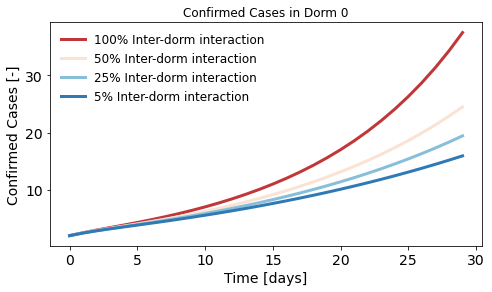

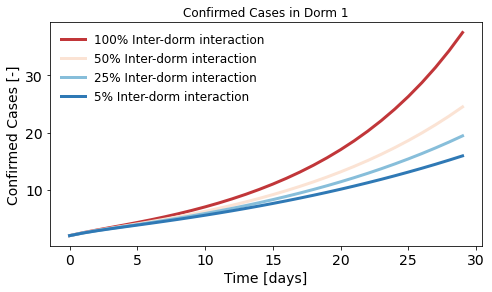

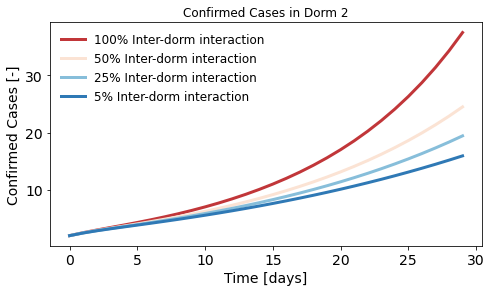

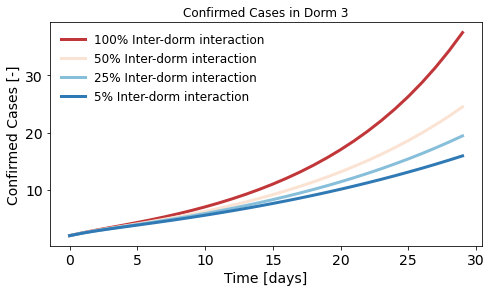

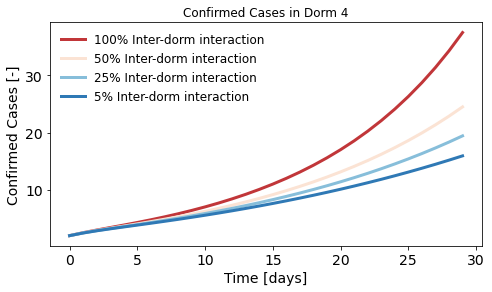

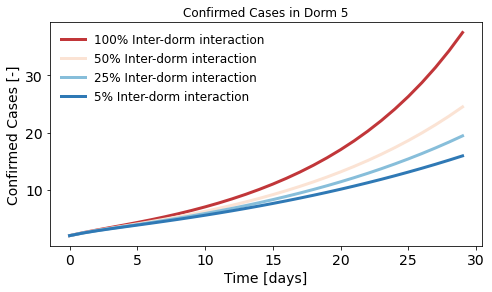

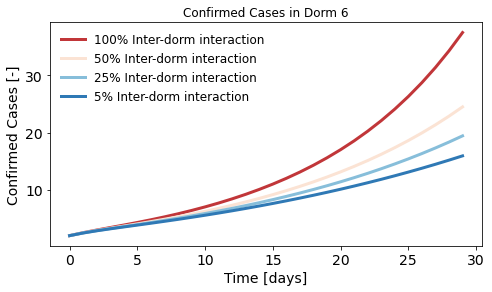

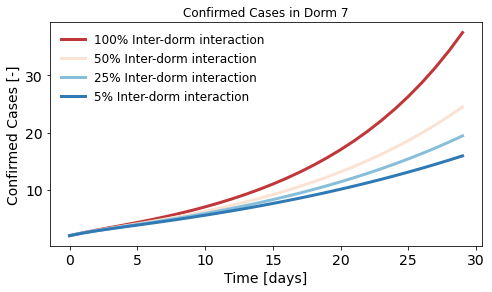

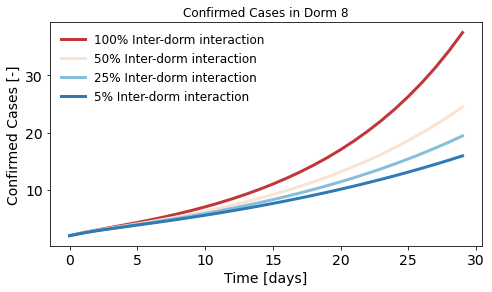

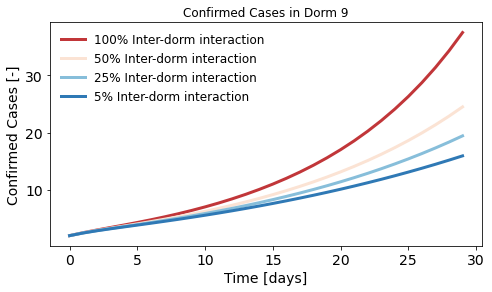

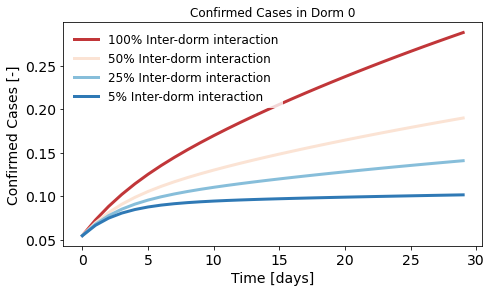

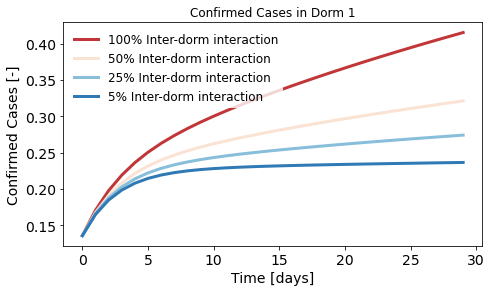

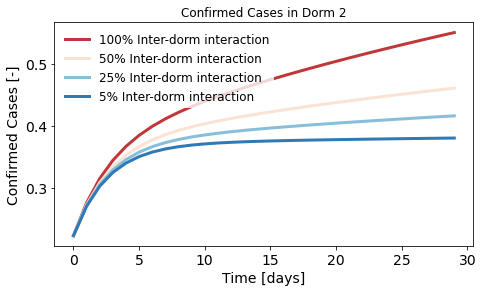

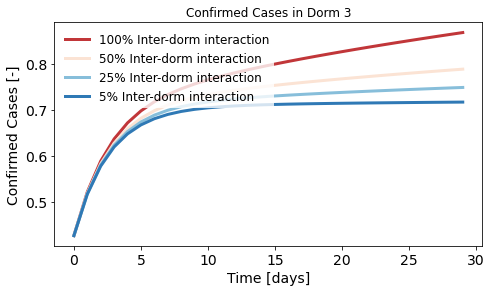

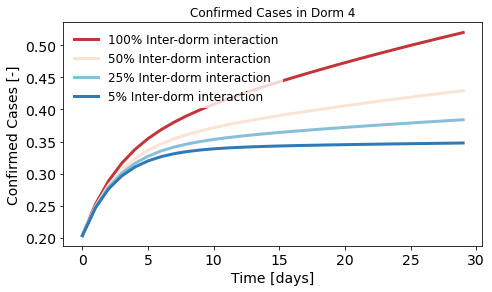

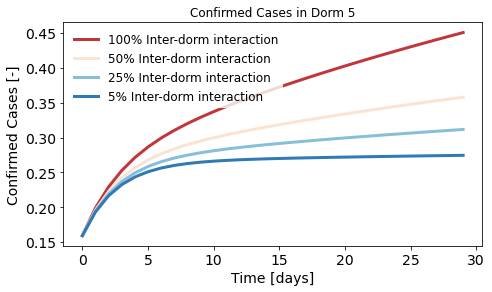

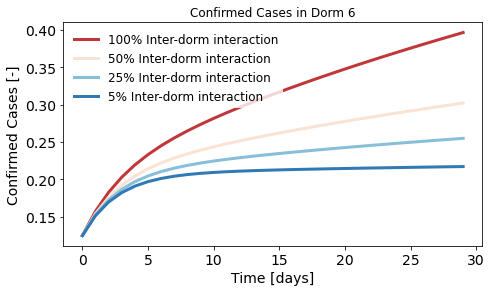

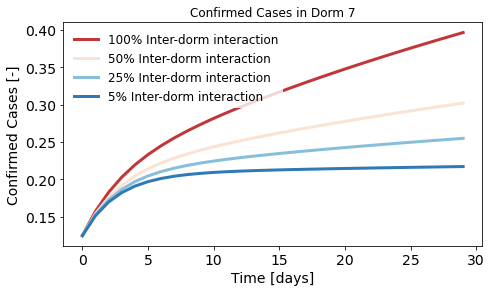

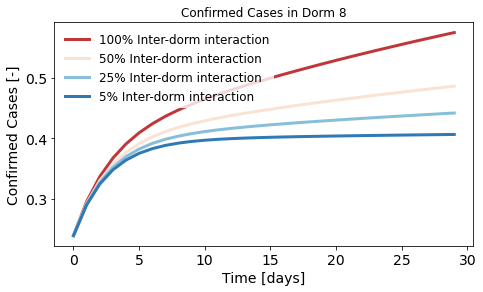

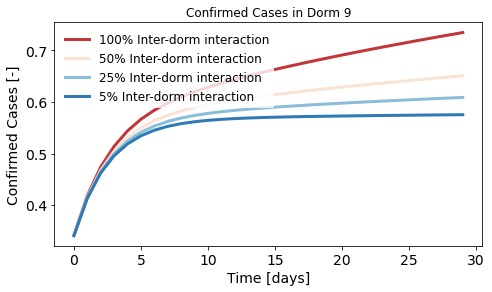

In [21]:
dorm_results_control = get_Results_By_Dorm(interact_table_control)

dorm_results_by_risk = get_Results_By_Dorm(interact_table_by_risk)

# Aggregating Results
Here, we gather up all the dorm-specific data we have to get university-wide results for each assignment mechanism.

In [16]:
def aggregate_results(dorm_results):
    # dorm_results: pd dataframe or np array, each row is time series of data for a dorm
    
    #Return: single time series that is weighted average of the dorm_results
    
    #Do stuff that should basically amount to getting weighted average of all the dorms
    
    #For each row, multiply the whole row by the pop of that dorm
    ####TODO####
    
    #Sum all the rows together
    confirmed_total = np.mean(np.array(dorm_results["0"]), axis=0)
    
    confirmed_total_50 = np.mean(np.array(dorm_results["50"]), axis=0)
    
    confirmed_total_75 = np.mean(np.array(dorm_results["75"]), axis=0)
    
    confirmed_total_95 = np.mean(np.array(dorm_results["95"]), axis=0)
    
    #%% ################### Plot results #######################################
    t = np.arange(0,Tmax, dt)
    days = np.arange(0,Tmax, 1)
    skip = int(1/dt)
    # color palette
    Color_p = sns.color_palette("RdBu", 6)
    fig, ax1 = plt.subplots(figsize=(500/72,300/72))
    ax1.plot(days, confirmed_total[::skip],color = Color_p[0],lw=3,zorder=1, label=r'prediction 0% quarantine') # 
    ax1.plot(days, confirmed_total_50[::skip],color = Color_p[2],lw=3,zorder=1, label=r'prediction 50% quarantine') #
    ax1.plot(days, confirmed_total_75[::skip],color = Color_p[4],lw=3,zorder=1, label=r'prediction 75% quarantine') # 
    ax1.plot(days, confirmed_total_95[::skip],color = Color_p[5],lw=3,zorder=1, label=r'prediction 95% quarantine') # 
    leg = plt.legend(loc='upper left',fontsize='large',frameon=True)
    leg.get_frame().set_linewidth(0.0)
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    plt.ylabel('confirmed cases [-]',fontsize=14)
    plt.xlabel('time [days]',fontsize=14)
    plt.title('Confirmed Cases in Entire Campus')
    plt.tight_layout()
    
    #Divide by total pop, we now have weighted average
    return aggregated_results/total_students

In [17]:
control_agg = aggregate_results(dorm_results_control)

by_risk_agg = aggregate_results(dorm_results_by_risk)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Aggregated Analysis and Plots
If there's any plots and stuff we wanna make with the aggregated results, put that here.